In [ ]:
# This notebook illustrates the relative performances of the rejection sampling algorithm of Makalic and Schmidt [1] v.s.
# the inverse transform algorithm of Opdyke [2] when generating random samples from the Makalic and Schmidt distribution.
#
# Makalic and Schmidt distribution, with PDF (sin(theta))^k, k>=1, 0<theta<pi, is used in the generation of 
# random correlation matrices, through the generation of the associated correlative angles, c.f. [1].


# References:
# [1] Enes Makalic & Daniel F. Schmidt (2022) "An efficient algorithm for sampling from sink(x) for generating random correlation matrices"
#     Communications in Statistics - Simulation and Computation, 51:5, 2731-2735
#     https://www.tandfonline.com/doi/abs/10.1080/03610918.2019.1700277?journalCode=lssp20
#
# [2] Opdyke, JD, "Beating the Correlation Breakdown (for Pearsons', Kendall's, Spearman's, and MORE!): Robust Inference and Flexible Scenarios and Stress Testing for Financial Portfolios" 
#     https://ssrn.com/abstract=4056268

In [48]:
import numpy as np
from scipy.stats import beta
from scipy.stats import uniform
import scipy.special as sc

# Function to generate random variates from the Makalic and Schmidt's distribution, 
# using rejection sampling, c.f. [1]
def sinkrndRejection(k):
    # Rejection loop
    while True:
        #
        x =  0 + beta.rvs(k+1, k+1) * (np.pi - 0) # scaled Beta distribution from [0,1] to [0, pi]
        u = uniform.rvs()
        
        #
        if ( np.log(u) <= k * np.log( (np.pi**2 * np.sin(x)) / (4 * x * (np.pi - x)) ) ):
            break

    #
    return x

# Function to generate random variates from the Makalic and Schmidt's distribution, 
# using inverse transform, c.f. [2]
def sinkrndInverse(k):
    #
    u = uniform.rvs()
    
    #
    if u < 0.5:
        x = np.arccos( np.sqrt( sc.betaincinv(1/2, (1+k)/2, 1-2*u) ) )
    else:
        x = np.pi - np.arccos( np.sqrt( sc.betaincinv(1/2, (1+k)/2, 1-2*(1-u)) ) )
    
    #
    return x

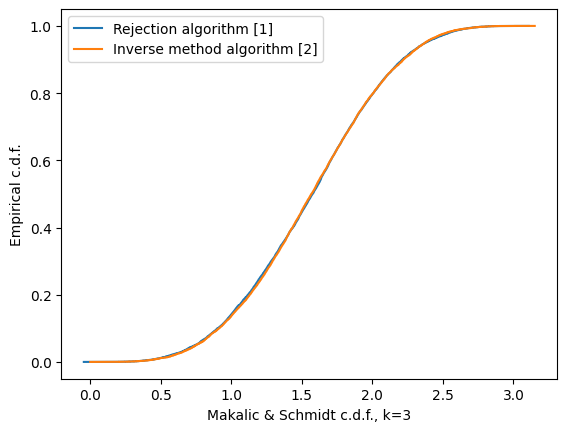

In [49]:
from scipy import stats
import matplotlib.pyplot as plt

# Let's first validate graphically that the distributions of the random variables are identical, 
# using a specific k

# Parameters
k = 3
samples = 10000


# Random samples generation
xRejection, xInverse = [], []
for i in range(samples):
    xRejection += [sinkrndRejection(k)]
    xInverse += [sinkrndInverse(k)]


# Computation of empirical cdfs
ecdfRejection = stats.ecdf(xRejection)
ecdfInverse = stats.ecdf(xInverse)


# Plot
ax = plt.subplot()
ecdfRejection.cdf.plot(ax, label="Rejection algorithm [1]")
ecdfInverse.cdf.plot(ax, label="Inverse method algorithm [2]")
ax.set_xlabel('Makalic & Schmidt c.d.f., k=' + str(k))
ax.set_ylabel('Empirical c.d.f.')
ax.legend()
plt.show()

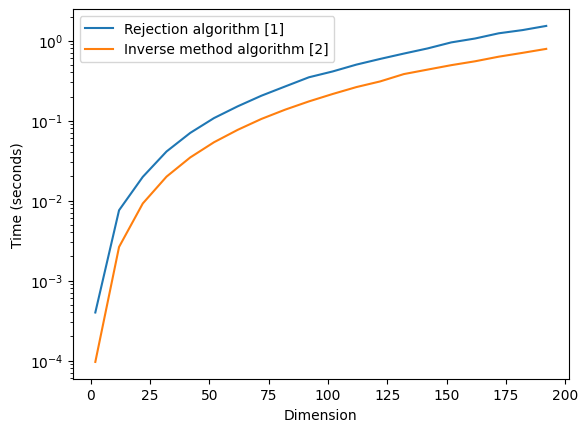

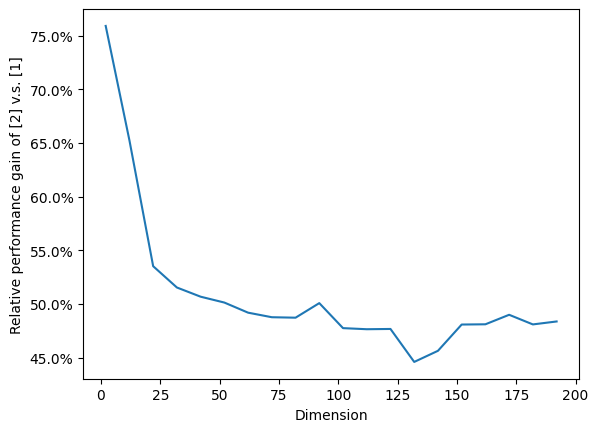

In [55]:
import timeit
from functools import partial
import matplotlib.ticker as mtick

# Let's now generate the n(n-1)/2 correlative angles corresponding to a random correlation matrix of order n, 
# for several values of n, and measure the relative performances of the two sampling algorithms.

## Functions definition

# Generate n(n-1)/2 correlative angles using the sampling algorithm in input
def correlativeAngles(func, n):
    #
    angles = []
    for j in range(1, n+1):
        for i in range(j+1, n+1):
            angles += [func(n-j)]

    #
    return angles

# Measure the time taken to generate n(n-1)/2 correlative angles, using the sampling algorithm in input
def measureCorrelativeAnglesGenerationTime(func, n):
    #
    x, y = [], []
    
    #
    for i in range(2, n+1, 10):
        timer = timeit.Timer(partial(correlativeAngles, func, i))
        t = timer.repeat(repeat=1, number=1)
        x.append(i)
        y.append(np.mean(t))
    
    #
    return x, y


## Core process

# Parameters
n = 200

# Generation time measures
xRejection, yRejection = measureCorrelativeAnglesGenerationTime(sinkrndRejection, n)
xInverse, yInverse = measureCorrelativeAnglesGenerationTime(sinkrndInverse, n)


## Plot

# Plot the performance measures
plt.plot(xRejection, yRejection, label="Rejection algorithm [1]")
plt.plot(xInverse, yInverse, label="Inverse method algorithm [2]")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Time (seconds)")
plt.yscale('log')
plt.show()

# Plot the average performances gain in %
ax = plt.subplot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.plot(xRejection, (1-np.array(yInverse)/np.array(yRejection))*100)
plt.xlabel("Dimension")
plt.ylabel("Relative performance gain of [2] v.s. [1]")
plt.show()
